In [1]:
from datasets import get_dataset_config_names 

domains = get_dataset_config_names("subjqa")
domains 


['books', 'electronics', 'grocery', 'movies', 'restaurants', 'tripadvisor']

In [2]:
from datasets import load_dataset 

subjqa = load_dataset("subjqa", name="electronics")
print(subjqa["train"]["answers"][1])


Found cached dataset subjqa (/home/jim/.cache/huggingface/datasets/subjqa/electronics/1.1.0/2c12e496c4c675ab4a57ffb5d3f538f2e7b89793956e50da37126393ce23b6c6)


  0%|          | 0/3 [00:00<?, ?it/s]

{'text': ['Bass is weak as expected', 'Bass is weak as expected, even with EQ adjusted up'], 'answer_start': [1302, 1302], 'answer_subj_level': [1, 1], 'ans_subj_score': [0.5083333253860474, 0.5083333253860474], 'is_ans_subjective': [True, True]}


In [3]:
import pandas as pd 

dfs = {split: dset.to_pandas() for split, dset in subjqa.flatten().items()}

for split, df in dfs.items():
  print(f"Number of questions in {split}: {df['id'].nunique()}")
  

Number of questions in train: 1295
Number of questions in test: 358
Number of questions in validation: 255


In [4]:
qa_cols = ["title", "question", "answers.text", 
           "answers.answer_start", "context"]
sample_df = dfs["train"][qa_cols].sample(2, random_state=7)
sample_df 


,title,question,answers.text,answers.answer_start,context
791,B005DKZTMG,Does the keyboard lightweight?,[this keyboard is compact],[215],I really like this keyboard. I give it 4 star...
1159,B00AAIPT76,How is the battery?,[],[],I bought this after the first spare gopro batt...


In [5]:
start_idx = sample_df["answers.answer_start"].iloc[0][0]
end_idx = start_idx + len(sample_df["answers.text"].iloc[0][0])
sample_df["context"].iloc[0][start_idx:end_idx]


'this keyboard is compact'

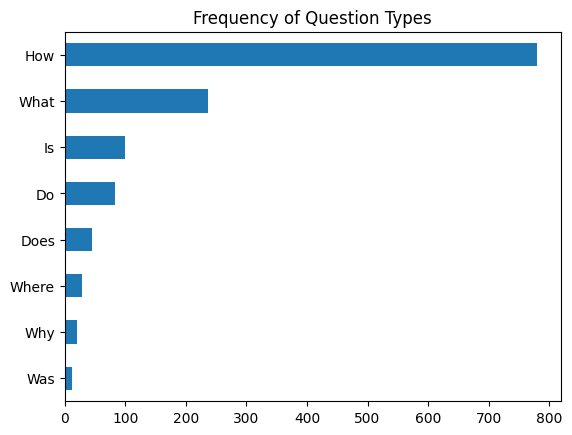

In [6]:
import matplotlib.pyplot as plt

counts = {}
question_types = ["What", "How", "Is", "Does", "Do", "Was", "Where", "Why"]

for q in question_types:
  counts[q] = dfs["train"]["question"].str.startswith(q).value_counts()[True]

pd.Series(counts).sort_values().plot.barh()
plt.title("Frequency of Question Types")
plt.show()


In [7]:
for question_type in ["How", "What", "Is"]:
  for question in (
      dfs["train"][dfs["train"].question.str.startswith(question_type)]
      .sample(n=3, random_state=42)['question']):
    print(question)


How is the camera?
How do you like the control?
How fast is the charger?
What is direction?
What is the quality of the construction of the bag?
What is your impression of the product?
Is this how zoom works?
Is sound clear?
Is it a wireless keyboard?


In [8]:
from transformers import AutoTokenizer 

model_ckpt = "deepset/minilm-uncased-squad2"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

question = "How much music can this hold?"
context = """An MP3 is about 1 MB/minute, so about 6000 hours depending on file size."""
inputs = tokenizer(question, context, return_tensors="pt")


2023-05-24 12:02:04.914150: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-24 12:02:05.055137: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-05-24 12:02:05.055155: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-05-24 12:02:05.755999: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

In [9]:
print(tokenizer.decode(inputs["input_ids"][0]))

[CLS] how much music can this hold? [SEP] an mp3 is about 1 mb / minute, so about 6000 hours depending on file size. [SEP]


In [10]:
import torch 
from transformers import AutoModelForQuestionAnswering

model = AutoModelForQuestionAnswering.from_pretrained(model_ckpt)

with torch.no_grad():
  outputs = model(**inputs)
print(outputs)



QuestionAnsweringModelOutput(loss=None, start_logits=tensor([[-0.9862, -4.7750, -5.4025, -5.2378, -5.2863, -5.5117, -4.9819, -6.1880,
         -0.9862,  0.2596, -0.2144, -1.7136,  3.7806,  4.8561, -1.0546, -3.9097,
         -1.7374, -4.5944, -1.4278,  3.9949,  5.0391, -0.2018, -3.0193, -4.8549,
         -2.3108, -3.5110, -3.5713, -0.9862]]), end_logits=tensor([[-0.9623, -5.4733, -5.0326, -5.1639, -5.4278, -5.5151, -5.1749, -4.6233,
         -0.9623, -3.7855, -0.8715, -3.7745, -3.0161, -1.1780,  0.1758, -2.7365,
          4.8934,  0.3046, -3.1761, -3.2762,  0.8937,  5.6606, -0.3623, -4.9554,
         -3.2531, -0.0914,  1.6211, -0.9623]]), hidden_states=None, attentions=None)


In [11]:
start_logits = outputs.start_logits 
end_logits = outputs.end_logits 

print(f"Input IDs shape: {inputs.input_ids.size()}")
print(f"Start logits shape: {start_logits.size()}")
print(f"End logits shape: {end_logits.size()}")


Input IDs shape: torch.Size([1, 28])
Start logits shape: torch.Size([1, 28])
End logits shape: torch.Size([1, 28])


In [12]:
import torch 

start_idx = torch.argmax(start_logits)
end_idx = torch.argmax(end_logits) + 1
answer_span = inputs["input_ids"][0][start_idx:end_idx]
answer = tokenizer.decode(answer_span)
print(f"Question: {question}")
print(f"Answer: {answer}")


Question: How much music can this hold?
Answer: 6000 hours


In [13]:
from transformers import pipeline 

pipe = pipeline("question-answering", model=model, tokenizer=tokenizer)
pipe(question=question, context=context, topk=3)


/home/jim/anaconda3/envs/cvml/lib/python3.9/site-packages/transformers/pipelines/question_answering.py:325: UserWarning: topk parameter is deprecated, use top_k instead
  warnings.warn("topk parameter is deprecated, use top_k instead", UserWarning)


[{'score': 0.2651607394218445, 'start': 38, 'end': 48, 'answer': '6000 hours'},
 {'score': 0.2208300530910492,
  'start': 16,
  'end': 48,
  'answer': '1 MB/minute, so about 6000 hours'},
 {'score': 0.10253580659627914,
  'start': 16,
  'end': 27,
  'answer': '1 MB/minute'}]

In [14]:
pipe(question="Why is there no data?", context=context, 
     handle_impossible_answer=True)

{'score': 0.9068413972854614, 'start': 0, 'end': 0, 'answer': ''}

In [15]:
example = dfs["train"].iloc[0][["question", "context"]]
tokenized_example = tokenizer(example["question"], example["context"], 
                              return_overflowing_tokens=True, max_length=100, 
                              stride=25)

for idx, window in enumerate(tokenized_example["input_ids"]):
  print(f"Window ${idx} has {len(window)} tokens")
  

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Window $0 has 100 tokens
Window $1 has 88 tokens


In [16]:
for window in tokenized_example["input_ids"]:
  print(f"{tokenizer.decode(window)} \n")
  

[CLS] how is the bass? [SEP] i have had koss headphones in the past, pro 4aa and qz - 99. the koss portapro is portable and has great bass response. the work great with my android phone and can be " rolled up " to be carried in my motorcycle jacket or computer bag without getting crunched. they are very light and do not feel heavy or bear down on your ears even after listening to music with them on all day. the sound is [SEP] 

[CLS] how is the bass? [SEP] and do not feel heavy or bear down on your ears even after listening to music with them on all day. the sound is night and day better than any ear - bud could be and are almost as good as the pro 4aa. they are " open air " headphones so you cannot match the bass to the sealed types, but it comes close. for $ 32, you cannot go wrong. [SEP] 



In [17]:
# on Linux
url = """https://artifacts.elastic.co/downloads/elasticsearch/elasticsearch-7.9.2-linux-x86_64.tar.gz"""
!wget -nc -q {url}
!tar -xzf elasticsearch-7.9.2-linux-x86_64.tar.gz

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [18]:
"""
It seems that you are trying to run Elasticsearch as a background process and change the user and group ownership of the Elasticsearch directory to daemon using the chown command. However, in the preexec_fn parameter of the Popen function, you are trying to set the user ID of the current process to 1 using os.setuid(1). This could be causing the SubprocessError: Exception occurred in preexec_fn error. Can you try removing the preexec_fn parameter and see if that resolves the issue?
"""

import os 
from subprocess import Popen, PIPE, STDOUT 

# Run Elasticsearch as a background process 
!chown -R jim:jim elasticsearch-7.9.2 
es_server = Popen(args=['elasticsearch-7.9.2/bin/elasticsearch'], 
                  stdout=PIPE, stderr=STDOUT) #, preexec_fn=lambda: os.setuid(1))
# Wait until Elasticsearch has started 
!sleep 30

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [19]:
# es_server.terminate()

In [20]:
!curl -X GET "localhost:9200/?pretty" 

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
{
  "name" : "Ubuntu",
  "cluster_name" : "elasticsearch",
  "cluster_uuid" : "MI92LZckQX2QZkIq13QU5g",
  "version" : {
    "number" : "7.9.2",
    "build_flavor" : "default",
    "build_type" : "tar",
    "build_hash" : "d34da0ea4a966c4e49417f2da2f244e3e97b4e6e",
    "build_date" : "2020-09-23T00:45:33.626720Z",
    "build_snapshot" : false,
    "lucene_version" : "8.6.2",
    "minimum_wire_compatibility_version" : "6.8.0",
    "minimum_index_compatibility_version" : "6.0.0-beta1"
  },
  "tagline" : "You Know, for Search"
}


In [21]:
# !pip install --upgrade pip
# !pip install 'farm-haystack[all]' ## or 'all-gpu' for the GPU-enabled dependencies

In [22]:
"""
in versions 1.x of Haystack, the import changed from
from haystack.document_store... to from haystack.document_stores....
"""

from haystack.document_stores.elasticsearch import ElasticsearchDocumentStore

# return the document embedding for later use with dense retriever
document_store = ElasticsearchDocumentStore(return_embedding=True)



huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [23]:
# it's a good idea to flush elasticsearch with each notebook restart
if len(document_store.get_all_documents()) or len(document_store.get_all_labels()) > 0:
  document_store.delete_documents(index="document")
  document_store.delete_documents(index="label")

In [24]:
for split, df in dfs.items():
  # exclude duplicate reviews
  docs = [{"content": row["context"], "id": row["review_id"], 
           "meta": {"item_id": row["title"], "question_id": row["id"], 
                    "split": split}}
          for _,row in df.drop_duplicates(subset="context").iterrows()]
  document_store.write_documents(documents=docs, index="document")

print(f"Loaded {document_store.get_document_count()} documents")


Loaded 1615 documents


In [25]:
from haystack.nodes.retriever import BM25Retriever

bm25_retriever = BM25Retriever(document_store=document_store)

item_id = "B0074BW614"
query = "Is it good for reading?"
retrieved_docs = bm25_retriever.retrieve(
    query=query, 
    top_k=3, 
    filters={"item_id": [item_id], 
             "split": ["train"]})
print(retrieved_docs[0])


<Document: id=4a6aa9c7808ebba8d35aeecbcc3c30fe, content='This is a gift to myself.  I have been a kindle user for 4 years and this is my third one.  I never ...'>


In [26]:
from haystack.nodes import FARMReader 

model_ckpt = "deepset/minilm-uncased-squad2"
max_seq_length, doc_stride = 384, 128
reader = FARMReader(model_name_or_path=model_ckpt, progress_bar=False, 
                    max_seq_len=max_seq_length, doc_stride=doc_stride, 
                    return_no_answer=True)
print(reader.predict_on_texts(question=question, texts=[context], top_k=1))


/home/jim/anaconda3/envs/cvml/lib/python3.9/site-packages/torch/_utils.py:776: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


{'query': 'How much music can this hold?', 'no_ans_gap': 12.648090839385986, 'answers': [<Answer {'answer': '6000 hours', 'type': 'extractive', 'score': 0.5293056964874268, 'context': 'An MP3 is about 1 MB/minute, so about 6000 hours depending on file size.', 'offsets_in_document': [{'start': 38, 'end': 48}], 'offsets_in_context': [{'start': 38, 'end': 48}], 'document_ids': ['e344757014e804eff50faa3ecf1c9c75'], 'meta': {}}>]}


In [27]:
from haystack.pipelines import ExtractiveQAPipeline

pipe = ExtractiveQAPipeline(reader=reader, retriever=bm25_retriever)

n_answers = 3
preds = pipe.run(query=query, 
                 params={"Retriever": {"top_k": 3, 
                                       "filters": {"item_id": [item_id], 
                                                   "split": ["train"]}}, 
                         "Reader": {"top_k": n_answers}})

print(f"Question: {preds['query']} \n")

for idx in range(n_answers):
  print(f"Answer {idx+1}: {preds['answers'][idx].answer}")
  print(f"Review snippet: ...{preds['answers'][idx].context}...")
  print("\n\n")


Question: Is it good for reading? 

Answer 1: it is great for reading books when no light is available
Review snippet: ...ecoming addicted to hers! Our son LOVES it and it is great for reading books when no light is available. Amazing sound but I suggest good headphones t...



Answer 2: I mainly use it for book reading
Review snippet: ... is my third one.  I never thought I would want a fire for I mainly use it for book reading.  I decided to try the fire for when I travel I take my la...



Answer 3: 
Review snippet: ...None...





In [28]:
from haystack.pipelines import DocumentSearchPipeline

pipe = DocumentSearchPipeline(retriever=bm25_retriever)

In [29]:
from haystack import Label, Answer, Document

labels = []
for i, row in dfs["test"].iterrows():
  # Metadata used for filtering in the Retriever
  meta = {"item_id": row["title"], "question_id": row["id"]}
  # Populate labels for questions with answers
  if len(row["answers.text"]):
    for answer in row["answers.text"]:
      label = Label(
          query=row["question"], 
          answer=Answer(answer=answer), 
          origin="gold-label", 
          document=Document(content=row["context"], id=row["review_id"]),
          meta=meta, 
          is_correct_answer=True, 
          is_correct_document=True,
          no_answer=False, 
          filters={"item_id": [meta["item_id"]], "split":["test"]})
      labels.append(label)
  # Populate labels for questions without answers
  else:
    label = Label(
        query=row["question"], 
        answer=Answer(answer=""), 
        origin="gold-label", 
        document=Document(content=row["context"], id=row["review_id"]),
        meta=meta, 
        is_correct_answer=True, 
        is_correct_document=True,
        no_answer=True, 
        filters={"item_id": [row["title"]], "split":["test"]})  
    labels.append(label)

In [30]:
document_store.write_labels(labels, index="label")

print(f"""Loaded {document_store.get_label_count(index="label")} \
    question-answer pairs""")

Loaded 455     question-answer pairs


In [31]:
labels_agg = document_store.get_all_labels_aggregated(
    index="label", 
    open_domain=True, 
    aggregate_by_meta=["item_id"])
print(len(labels_agg))


330


In [32]:
# We can run the pipeline with the desired top_k value like this 
eval_result = pipe.eval(
    labels=labels_agg, 
    params={"Retriever": {"top_k": 3}}, 
)
metrics = eval_result.calculate_metrics()
print(f"Recall@3: {metrics['Retriever']['recall_single_hit']:.2f}")


Recall@3: 0.96


In [33]:
eval_df = eval_result["Retriever"]
eval_df[eval_df["query"] == "How do you like the lens?"] 

,multilabel_id,query,filters,gold_answers,context,gold_contexts,gold_id_match,context_match,answer_match,gold_id_or_answer_match,...,rank,document_id,gold_document_ids,gold_documents_id_match,gold_contexts_similarity,gold_answers_match,type,node,eval_mode,index
0,aaa91c394ba2060b8d71016680661d9f,How do you like the lens?,"b'{""item_id"": [""B00006I53S""], ""split"": [""test""]}'",[I do recommend this lens],I bought this lens for my Canon 20D digital camera and have found it to be a...,[I bought this lens for my Canon 20D digital camera and have found it to be ...,1.0,1.0,1.0,1.0,...,1.0,fac2e8bec06035a70307dd1e8034ea63,[fac2e8bec06035a70307dd1e8034ea63],[1.0],[100.0],[1.0],document,Retriever,integrated,0
1,aaa91c394ba2060b8d71016680661d9f,How do you like the lens?,"b'{""item_id"": [""B00006I53S""], ""split"": [""test""]}'",[I do recommend this lens],I am not a professional or expert photographer...so take these comments with...,[I bought this lens for my Canon 20D digital camera and have found it to be ...,0.0,0.0,0.0,0.0,...,2.0,26bf35fe7f9a73d28535d5072ab17714,[fac2e8bec06035a70307dd1e8034ea63],[0.0],[44.576405384006335],[0.0],document,Retriever,integrated,1
0,146534b272300399201f19da0593f724,How do you like the lens?,"b'{""item_id"": [""B00007E7JU""], ""split"": [""test""]}'",[],I think that the title says it all. It is one of the cheapest lens on the ma...,[],0.0,0.0,0.0,0.0,...,1.0,9cae133919a2dc476c371cde9e5effb8,[],[],[],[0.0],document,Retriever,integrated,0
1,146534b272300399201f19da0593f724,How do you like the lens?,"b'{""item_id"": [""B00007E7JU""], ""split"": [""test""]}'",[],I bough this lens for a relative who bought my old canon rebel xti from me (...,[],0.0,0.0,0.0,0.0,...,2.0,a1f6e39766a79f1475b3dbe07e517e04,[],[],[],[0.0],document,Retriever,integrated,1
2,146534b272300399201f19da0593f724,How do you like the lens?,"b'{""item_id"": [""B00007E7JU""], ""split"": [""test""]}'",[],"I fell in love with the lens the moment I started using it. sure, the build ...",[],0.0,0.0,0.0,0.0,...,3.0,0fc71a2e4ec350e845ed384717792ad8,[],[],[],[0.0],document,Retriever,integrated,2
0,f2a3d71cf9b19a31dadde09d82e76f5a,How do you like the lens?,"b'{""item_id"": [""B0025EWXEU""], ""split"": [""test""]}'","[than you're used to compared to Nikon or Zeiss lenses, I have read a lot of...","I have read a lot of negative press about this lens, but I have to tell you ...","[I have read a lot of negative press about this lens, but I have to tell you...",1.0,1.0,1.0,1.0,...,1.0,47f76b8f62cf296d394d993741d660aa,"[47f76b8f62cf296d394d993741d660aa, 47f76b8f62cf296d394d993741d660aa]","[1.0, 1.0]","[100.0, 100.0]","[1.0, 1.0]",document,Retriever,integrated,0


In [34]:
def evaluate_retriever(retriever, topk_values=[1,3,5,10,20]):
  topk_results = {}
  # calculate max topk
  max_top_k = max(topk_values)
  # crate pipeline
  p = DocumentSearchPipeline(retriever=retriever)
  # run inference with max topk by looping over each queston-answers pair in the test set
  eval_result = p.eval(
      labels=labels_agg, 
      params={"Retriever": {"top_k": max_top_k}}
  )
  # calculate metric for each topk value
  for topk in topk_values:
    # get metrics
    metrics = eval_result.calculate_metrics(simulated_top_k_retriever=topk)
    topk_results[topk] = {"recall": metrics["Retriever"]["recall_single_hit"]}

  return pd.DataFrame.from_dict(topk_results, orient="index") 

bm25_topk_df = evaluate_retriever(bm25_retriever)


/home/jim/anaconda3/envs/cvml/lib/python3.9/site-packages/haystack/schema.py:1414: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  documents["matched_label_idxs"] = documents.apply(find_matched_label_idxs, axis=1)
/home/jim/anaconda3/envs/cvml/lib/python3.9/site-packages/haystack/schema.py:1414: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  documents["matched_label_idxs"] = documents.apply(find_matched_label_idxs, axis=1)
/home/jim/anaconda3/envs/cvml/lib/python3.9/site-packages/haystack/schema.py:1414: Setti

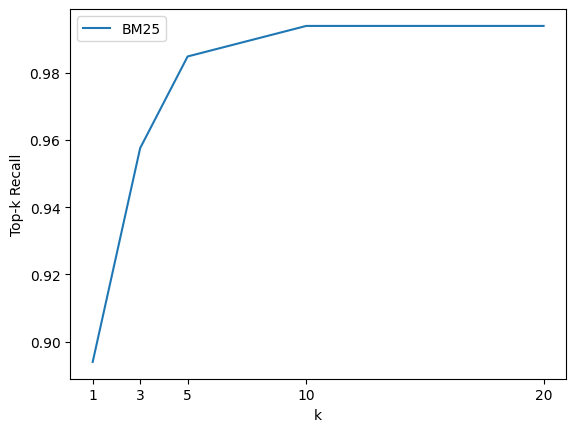

In [35]:
def plot_retriever_eval(dfs, retriever_names):
  fig, ax = plt.subplots()
  for df, retriever_name in zip(dfs, retriever_names):
    df.plot(y="recall", ax=ax, label=retriever_name)
  plt.xticks(df.index)
  plt.ylabel("Top-k Recall")
  plt.xlabel("k")
  plt.show()
  
plot_retriever_eval([bm25_topk_df], ["BM25"])


The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'DPRQuestionEncoderTokenizer'. 
The class this function is called from is 'DPRContextEncoderTokenizerFast'.


Updating embeddings:   0%|          | 0/1615 [00:00<?, ? Docs/s]

Create embeddings:   0%|          | 0/1616 [00:00<?, ? Docs/s]

/home/jim/anaconda3/envs/cvml/lib/python3.9/site-packages/haystack/schema.py:1414: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  documents["matched_label_idxs"] = documents.apply(find_matched_label_idxs, axis=1)
/home/jim/anaconda3/envs/cvml/lib/python3.9/site-packages/haystack/schema.py:1414: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  documents["matched_label_idxs"] = documents.apply(find_matched_label_idxs, axis=1)
/home/jim/anaconda3/envs/cvml/lib/python3.9/site-packages/haystack/schema.py:1414: Setti

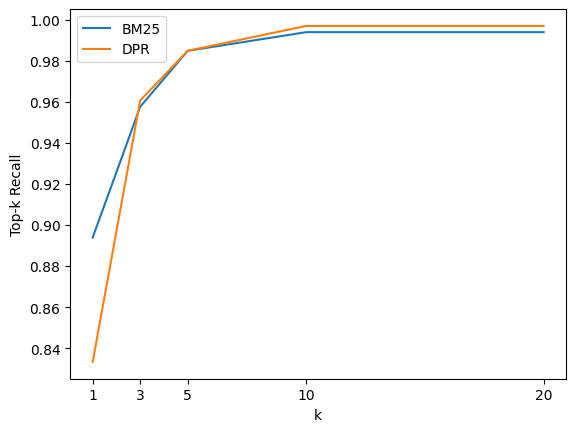

In [36]:
from haystack.nodes import DensePassageRetriever

dpr_retriever = DensePassageRetriever(
    document_store=document_store, 
    query_embedding_model="facebook/dpr-question_encoder-single-nq-base", 
    passage_embedding_model="facebook/dpr-ctx_encoder-single-nq-base", 
    embed_title=False)
document_store.update_embeddings(retriever=dpr_retriever)
dpr_topk_df = evaluate_retriever(dpr_retriever)
plot_retriever_eval([bm25_topk_df, dpr_topk_df], ["BM25", "DPR"])


In [37]:
from haystack.modeling.evaluation.squad import compute_f1, compute_exact

pred = "about 6000 hours"
label = "6000 hours"
print(f"EM: {compute_exact(label, pred)}")
print(f"F1: {compute_f1(label, pred)}")


EM: 0
F1: 0.8


In [38]:
pred = "about 6000 dollars"
print(f"EM: {compute_exact(label, pred)}")
print(f"F1: {compute_f1(label, pred)}")


EM: 0
F1: 0.4


In [39]:
from haystack.pipelines import Pipeline 
def evaluate_reader(reader):
  score_keys = ['exact_match', 'f1']
  p = Pipeline()
  p.add_node(component=reader, name="Reader", inputs=["Query"])

  eval_result = p.eval(
      labels=labels_agg, 
      documents=[[label.document for label in multilabel.labels] for multilabel in labels_agg], 
      params={},
  )
  metrics = eval_result.calculate_metrics(simulated_top_k_reader=1)

  return {k:v for k,v in metrics["Reader"].items() if k in score_keys}

reader_eval = {}
reader_eval["Fine-tune on SQuAD"] = evaluate_reader(reader)


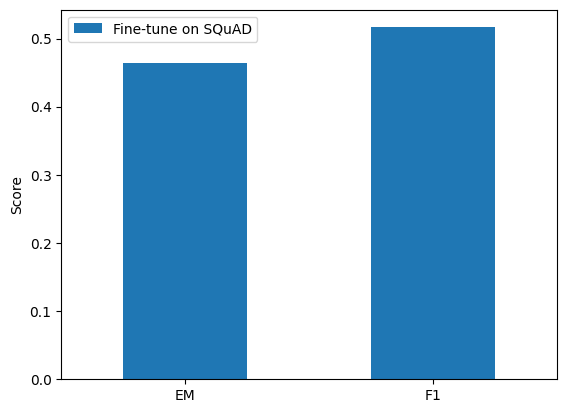

In [40]:
def plot_reader_eval(reader_eval):
  fig, ax = plt.subplots()
  df = pd.DataFrame.from_dict(reader_eval).reindex(["exact_match", "f1"])
  df.plot(kind="bar", ylabel="Score", rot=0, ax=ax)
  ax.set_xticklabels(["EM", "F1"])
  plt.legend(loc="upper left")
  plt.show()
  
plot_reader_eval(reader_eval)


In [41]:
def create_paragraphs(df):
  paragraphs = []
  id2context = dict(zip(df["review_id"], df["context"]))
  for review_id, review in id2context.items():
    qas = []
    # Filter for all question-answer pairs about a specific context
    review_df = df.query(f"review_id == '{review_id}'")
    id2question = dict(zip(review_df["id"], review_df["question"]))
    # Build up the qas array
    for qid, question in id2question.items():
      # Filter for a single question ID
      question_df = df.query(f"id == '{qid}'").to_dict(orient="list")
      ans_start_idxs = question_df["answers.answer_start"][0].tolist()
      ans_text = question_df["answers.text"][0].tolist()
      # Fill answerable questions
      if len(ans_start_idxs):
        answers = [
          {"text": text, "answer_start": answer_start}
          for text, answer_start in zip(ans_text, ans_start_idxs)]
        is_impossible = False
      else:
        answers = []
        is_impossible = True
      # Add question-answer pairs to qas
      qas.append({"question": question, "id": qid, 
            "is_impossible": is_impossible, "answers": answers})
    # Add context and question-answer pairs to paragraphs
    paragraphs.append({"qas": qas, "context": review})
  return paragraphs

In [42]:
product = dfs["train"].query("title == 'B00001P4ZH'")
create_paragraphs(product)


[{'qas': [{'question': 'How is the bass?',
    'id': '2543d296da9766d8d17d040ecc781699',
    'is_impossible': True,
    'answers': []}],
  'context': 'I have had Koss headphones in the past, Pro 4AA and QZ-99.  The Koss Portapro is portable AND has great bass response.  The work great with my Android phone and can be "rolled up" to be carried in my motorcycle jacket or computer bag without getting crunched.  They are very light and do not feel heavy or bear down on your ears even after listening to music with them on all day.  The sound is night and day better than any ear-bud could be and are almost as good as the Pro 4AA.  They are "open air" headphones so you cannot match the bass to the sealed types, but it comes close. For $32, you cannot go wrong.'},
 {'qas': [{'question': 'Is this music song have a goo bass?',
    'id': 'd476830bf9282e2b9033e2bb44bbb995',
    'is_impossible': False,
    'answers': [{'text': 'Bass is weak as expected', 'answer_start': 1302},
     {'text': 'Bass i

In [43]:
import json

def convert_to_squad(dfs):
  for split, df in dfs.items():
    subjqa_data = {}
    # Create `paragraphs` for each product ID
    groups = (df.groupby("title").apply(create_paragraphs)
      .to_frame(name="paragraphs").reset_index())
    subjqa_data["data"] = groups.to_dict(orient="records")
    # Save the result to disk
    with open(f"electronics-{split}.json", "w+", encoding="utf-8") as f:
      json.dump(subjqa_data, f)
      
convert_to_squad(dfs)


In [ ]:
train_filename = "electronics-train.json"
dev_filename = "electronics-validation.json"

reader.train(data_dir=".", use_gpu=True, n_epochs=1, batch_size=4, 
             train_filename=train_filename, dev_filename=dev_filename)
reader_eval["Fine-tune on SQuAD + SubjQA"] = evaluate_reader(reader)
plot_reader_eval(reader_eval)


In [ ]:
minilm_ckpt = "microsoft/MiniLM-L12-H384-uncased"
minilm_reader = FARMReader(model_name_or_path=minilm_ckpt, progress_bar=False,
                           max_seq_len=max_seq_length, doc_stride=doc_stride,
                           return_no_answer=True)
minilm_reader.train(data_dir=".", use_gpu=True, n_epochs=1, batch_size=16,
             train_filename=train_filename, dev_filename=dev_filename)
reader_eval["Fine-tune on SubjQA"] = evaluate_reader(minilm_reader)
plot_reader_eval(reader_eval)


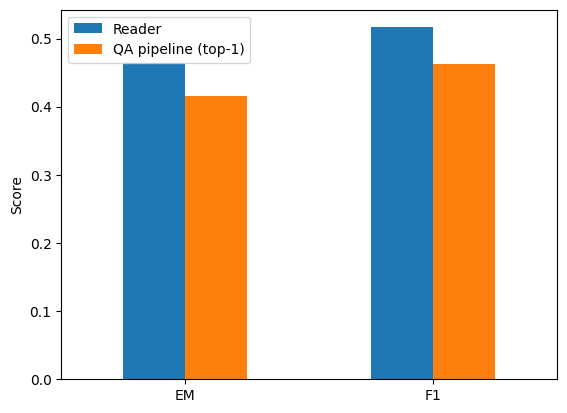

In [45]:
from haystack.pipelines import ExtractiveQAPipeline
pipe = ExtractiveQAPipeline(retriever=bm25_retriever, reader=reader)

# evaluate 
eval_result = pipe.eval(
    labels=labels_agg, 
    params={}, 
)
metrics = eval_result.calculate_metrics(simulated_top_k_reader=1)
# extract metrics from reader
reader_eval["QA Pipeline (top-1)"] = {
    k:v for k,v in metrics["Reader"].items() 
    if k in ["exact_match", "f1"]
}

#id reader-vs-pipeline
#caption Comparison of EM and _F_~1~ scores for the reader against the whole QA pipeline
plot_reader_eval({"Reader": reader_eval["Fine-tune on SQuAD"], 
                  "QA pipeline (top-1)": reader_eval["QA Pipeline (top-1)"]})

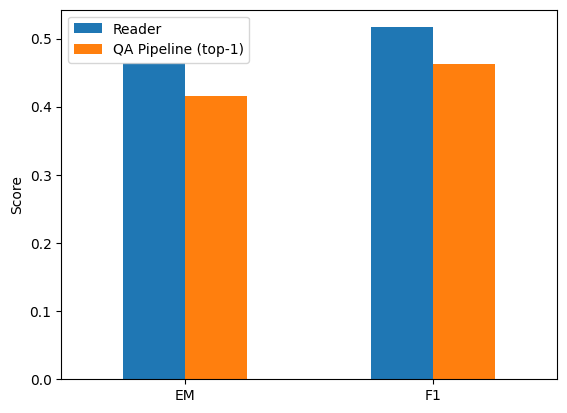

In [46]:
# Or get QA pipeline and Reader metrics in one shot:
# Reader evaluation is run a second time using simulated perfect retriever results
eval_result = pipe.eval(
    labels=labels_agg,
    params={},
    add_isolated_node_eval=True
)
metrics = eval_result.calculate_metrics(simulated_top_k_reader=1)
# Extract metrics from reader run in isolation with simulated perfect retriever
isolated_metrics = eval_result.calculate_metrics(simulated_top_k_reader=1, eval_mode="isolated")

pipeline_reader_eval = {}
pipeline_reader_eval["Reader"] = {
    k:v for k,v in isolated_metrics["Reader"].items()
    if k in ["exact_match", "f1"]}
pipeline_reader_eval["QA Pipeline (top-1)"] = {
    k:v for k,v in metrics["Reader"].items()
    if k in ["exact_match", "f1"]}

plot_reader_eval(pipeline_reader_eval)

**Going beyond extractive QA**

In [47]:
from haystack.nodes import RAGenerator 

generator = RAGenerator(model_name_or_path="facebook/rag-token-nq",
                        embed_title=False, num_beams=5)

/home/jim/anaconda3/envs/cvml/lib/python3.9/site-packages/haystack/nodes/answer_generator/transformers.py:116: DeprecationWarning: `RAGenerator` component is deprecated and will be removed in future versions. Use `PromptNode` instead of `RAGenerator`.
  warnings.warn(


/home/jim/anaconda3/envs/cvml/lib/python3.9/site-packages/transformers/models/bart/configuration_bart.py:179: UserWarning: Please make sure the config includes `forced_bos_token_id=0` in future versions. The config can simply be saved and uploaded again to be fixed.
  warnings.warn(


The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'RagTokenizer'. 
The class this function is called from is 'DPRQuestionEncoderTokenizer'.
The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'RagTokenizer'. 
The class this function is called from is 'DPRQuestionEncoderTokenizerFast'.


The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'RagTokenizer'. 
The class this function is called from is 'BartTokenizer'.
The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'RagTokenizer'. 
The class this function is called from is 'BartTokenizerFast'.


Some weights of the model checkpoint at facebook/rag-token-nq were not used when initializing RagTokenForGeneration: ['rag.question_encoder.question_encoder.bert_model.pooler.dense.bias', 'rag.question_encoder.question_encoder.bert_model.pooler.dense.weight']
- This IS expected if you are initializing RagTokenForGeneration from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RagTokenForGeneration from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RagTokenForGeneration were not initialized from the model checkpoint at facebook/rag-token-nq and are newly initialized: ['rag.generator.lm_head.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictio

In [50]:
from haystack.pipelines import GenerativeQAPipeline
pipe = GenerativeQAPipeline(generator=generator, retriever=dpr_retriever)

def generate_answers(query, top_k_generator=3):
  preds = pipe.run(query=query, 
                   params={"Retriever": {"top_k": 5,
                                         "filters": {"item_id": ["B0074BW614"]}
                                         }, 
                           "Generator": {"top_k": top_k_generator}})
  print(f"Question: {preds['query']} \n")
  for idx in range(top_k_generator):
    print(f"Answer {idx+1}: {preds['answers'][idx].answer}")
  
generate_answers(query)
generate_answers("What is the main drawback?")


/home/jim/anaconda3/envs/cvml/lib/python3.9/site-packages/transformers/generation/utils.py:2734: UserWarning: `max_length` is deprecated in this function, use `stopping_criteria=StoppingCriteriaList(MaxLengthCriteria(max_length=max_length))` instead.
  warnings.warn(


Question: Is it good for reading? 

Answer 1:  the screen is absolutely beautiful
Answer 2:  the Screen is absolutely beautiful
Answer 3:  Kindle fire
Question: What is the main drawback? 

Answer 1:  the price
Answer 2:  no flash support
Answer 3:  the cost
